In [1]:
%%capture
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install seaborn
!pip install unidecode
!pip install -U imbalanced-learn
!pip3 install pickle5

In [2]:
import tensorflow as tf
import pandas as pd
import warnings
import unidecode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle5 as pickle
import random
import os
import re
import nltk
nltk.download('stopwords')

from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Reshape, Dense, Dropout, Flatten, Input, MaxPooling2D, Convolution2D, Embedding, Concatenate
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score

sw = set(stopwords.words('english'))
os.environ['PYTHONHASHSEED']=str(23)
tf.random.set_seed(23)
random.seed(23)
warnings.filterwarnings('ignore')
np.random.seed(23)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Preprocessing

In [3]:
def remove_username(text):
  text = re.sub(r'\@[^\s]+', ' ', text)
  return text

def remove_newline(text):
  text = text.replace('\n', ' ')
  return text

def only_letters(text):
  text = re.sub(r'[^a-záâàãéêèẽíìîĩóòõôúùũû\s]+', ' ', text)
  return text

def remove_link(text):
  text = re.sub(r'www\.?[^\s]+', ' ', text)
  return text

def remove_hyperlink(text):
  text = re.sub(r'\<.?\>', ' ', text)
  return text

def remove_accent(text):
  text = unidecode.unidecode(text)
  return text

def adjustment_text(text):
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()
  return text

def remove_stopwords(text):
  text = [word for word in text.split() if word not in sw]
  text = ' '.join(text)
  return text

def remove_spam(text):
  text = re.sub(r'\&amp', ' ', text)
  text = re.sub(r'\&lt', ' ', text)
  text = re.sub(r'\&gt', ' ', text)
  text = re.sub(r'\#follow|\#followme|\#like|\#f4f|\#photooftheday', ' ', text)
  return text

def remove_slangs(text):
  text = re.sub(r' b4 ', ' before ', text)
  text = re.sub(r' 2b ', ' to be ', text)
  text = re.sub(r' 2morrow ', ' tomorrow ', text)
  text = re.sub(r' rn ', ' right now ', text)
  text = re.sub(r' brb ', ' be right back ', text)
  text = re.sub(r' mb ', ' my bad ', text)
  text = re.sub(r' luv ', ' love ', text)
  text = re.sub(r' b ', ' be ', text)
  text = re.sub(r' r ', ' are ', text)
  text = re.sub(r' u ', ' you ', text)
  text = re.sub(r' y ', ' why ', text)
  text = re.sub(r' ur ', ' your ', text)
  text = re.sub(r' hbd ', ' happy birthday ', text)
  text = re.sub(r' bday ', ' birthday ', text)
  text = re.sub(r' bihday ', ' birthday ', text)
  text = re.sub(r' omg ', ' oh my god ', text)
  text = re.sub(r' lol ', ' laughing out loud ', text)
  return text

def remove_abbreviations(text):
  text = re.sub(r" can\'t ", " can not ", text)
  text = re.sub(r" i\'m ", " i am ", text)
  text = re.sub(r" i\'ll ", " i will ", text)
  text = re.sub(r" i\'d ", " i would ", text)
  text = re.sub(r" i\'ve ", " i have ", text)
  text = re.sub(r" ain\'t ", " am not ", text)
  text = re.sub(r" haven\'t ", " have not ", text)
  text = re.sub(r" hasn\'t ", " has not ", text)
  text = re.sub(r" can\'t ", " can not ", text)
  text = re.sub(r" won\'t ", " will not ", text)
  text = re.sub(r" you\'re ", " you are ", text)
  text = re.sub(r" we\'re ", " we are ", text)
  text = re.sub(r" they\'re ", " they are ", text)
  text = re.sub(r" he\'s ", " he is ", text)
  text = re.sub(r" she\'s ", " she is ", text)
  text = re.sub(r" it\'s ", " it is ", text)
  text = re.sub(r" don\'t ", " do not ", text)
  text = re.sub(r" doesn\'t ", " does not ", text)
  text = re.sub(r" wouldn\'t ", " would not ", text)
  text = re.sub(r" couldn\'t ", " could not ", text)
  text = re.sub(r" shouldn\'t ", " should not ", text)
  return text

def remove_one_len_word(text):
  text = re.sub(r'\b[a-z]\b', ' ', text)
  return text

def preprocessing(data):
  data['cleaned_tweet'] = data['tweet'].apply(str)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x: x.lower())
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_newline)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_hyperlink)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_spam)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_link)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_username)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_abbreviations)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(only_letters)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_accent)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_slangs)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_stopwords)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_one_len_word)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(adjustment_text)
  return data

from google.colab import files
uploaded = files.upload()

!unzip model_140_units

In [4]:
model = keras.models.load_model('model_dropout_0.4_pool6.h5')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 300)      11652900    input_4[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 30, 300, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 1, 140)   126140      reshape_3[0][0]                  
____________________________________________________________________________________________

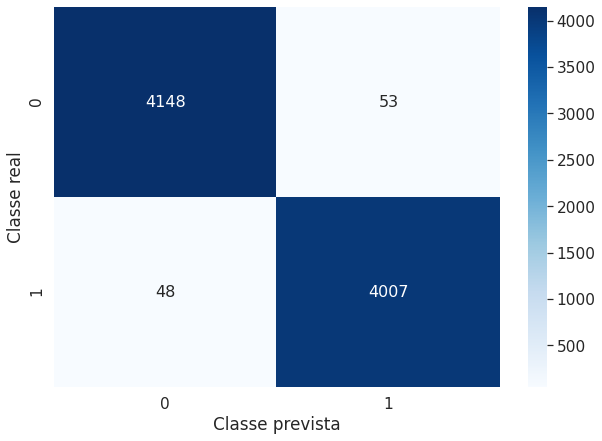

In [23]:
plt.figure(figsize = (10, 7))
predicted = (model.predict(X_validation) > 0.5).astype("int32")
matrix = confusion_matrix(y_validation, predicted, labels=[0, 1])
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, cmap="Blues", fmt='d', annot_kws={"size": 16})
plt.xlabel('Classe prevista')
plt.ylabel('Classe real')
plt.savefig('matriz_confusao.jpg')

In [5]:
normal_data = pd.read_csv('Data/train.csv')
normal_data = normal_data.drop(columns=['id'])
normal_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [6]:
normal_data.shape

(31962, 2)

In [7]:
preprocessed_data = normal_data.copy()
preprocessed_data = preprocessing(preprocessed_data)
preprocessed_data = preprocessed_data.replace('None', pd.NA)
preprocessed_data = preprocessed_data.dropna()
preprocessed_data = preprocessed_data.drop_duplicates()
preprocessed_data = preprocessed_data.drop(columns=['tweet'])
preprocessed_data = preprocessed_data.rename(columns={'cleaned_tweet': 'tweet'})
preprocessed_data.head()

,label,tweet
0,0,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit use cause offer wheelchair ...
2,0,birthday majesty
3,0,model love take time
4,0,factsguide society motivation


In [8]:
preprocessed_data.shape

(29530, 2)

In [9]:
ros = RandomOverSampler(random_state=23, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(preprocessed_data[['tweet']], preprocessed_data['label'])
data_preprocessing_augmentation = pd.concat([X_resampled, y_resampled], axis=1)
data_preprocessing_augmentation.head()

,tweet,label
0,father dysfunctional selfish drags kids dysfun...,0
1,thanks lyft credit use cause offer wheelchair ...,0
2,birthday majesty,0
3,model love take time,0
4,factsguide society motivation,0


## Tokenizer

In [10]:
with open(r"tokenizer_rand_preprocessing_augmentantion.pickle", "rb") as output_file:
    tokenizer = pickle.load(output_file)

## Parameters

In [11]:
non_linearity_function = 'relu'
kernel_size = [3, 4, 5]
filters = 100
dropout_rate = 0.5
l2_constraint = 3
epochs = 10
batch_size = 100
embedding_dim = 300
length_size = 30

## Predict

In [12]:
def predict(model, epoch):

  test = pd.read_csv('Data/test.csv')
  test = preprocessing(test)
  test['tokenized'] = tokenizer.texts_to_sequences(test['cleaned_tweet'].values)
  
  X_test = pad_sequences(sequences = test['tokenized'],
                         maxlen = length_size,
                         padding = 'post')

  predicted = (model.predict(X_test) > 0.5).astype("int32")
  prediction = pd.DataFrame()
  prediction['id'] = test['id']
  prediction['label'] = predicted
  prediction.to_csv('Submission/{}_epochs.csv'.format(epoch), index=False)

## Model

In [13]:
from keras.models import model_from_json

def cnn_rand(epoch):

  new_model = model_from_json(model.to_json())

  new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  history_random = new_model.fit(X_train, 
                                 y_train,
                                 batch_size=batch_size,
                                 epochs=epoch,
                                 validation_data=(X_validation, y_validation))
  
  predicted_validation = (new_model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(y_validation, predicted_validation, average='weighted')
  score = round(score, 4)

  save_model(new_model, epoch)
  predict(new_model, epoch)
  
  return score 

In [14]:
def save_model(modelo, epoch):
  file_name = 'model_'
  file_name = file_name + str(epoch) + '_epochs.h5'
  modelo.save('Model/' + file_name)

## Main

In [15]:
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(data_preprocessing_augmentation['tweet'].values)
data_preprocessing_augmentation['tokenized'] = tokenizer.texts_to_sequences(data_preprocessing_augmentation['tweet'].values)
vocab_size = len(tokenizer.word_index) + 1

X = pad_sequences(sequences = data_preprocessing_augmentation['tokenized'],
                  maxlen = length_size,
                  padding = 'post')

y = data_preprocessing_augmentation['label']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15, random_state=23)

test = pd.read_csv('Data/test.csv')
test = preprocessing(test)
test['tokenized'] = tokenizer.texts_to_sequences(test['cleaned_tweet'].values)

X_test = pad_sequences(sequences = test['tokenized'],
                       maxlen = length_size,
                       padding = 'post')

predicted = (model.predict(X_test) > 0.5).astype("int32")
prediction = pd.DataFrame()
prediction['id'] = test['id']
prediction['label'] = predicted
prediction.to_csv('Submission/aaaaaaaaaa.csv', index=False)

In [16]:
epochs = [4, 6, 8, 12, 14, 16]
scores = []

for epoch in epochs:
  print("Testando com {} epochs".format(epoch))
  score_validation = cnn_rand(epoch)
  scores.append(score_validation)
  print()

Testando com 4 epochs
Epoch 1/4
468/468 [==============================] - 221s 469ms/step - loss: 0.8328 - accuracy: 0.4988 - val_loss: 0.6934 - val_accuracy: 0.4912
Epoch 2/4
468/468 [==============================] - 218s 466ms/step - loss: 0.4267 - accuracy: 0.8371 - val_loss: 0.2290 - val_accuracy: 0.9528
Epoch 3/4
468/468 [==============================] - 216s 463ms/step - loss: 0.1915 - accuracy: 0.9584 - val_loss: 0.1623 - val_accuracy: 0.9661
Epoch 4/4
468/468 [==============================] - 220s 470ms/step - loss: 0.1403 - accuracy: 0.9738 - val_loss: 0.1577 - val_accuracy: 0.9671

Testando com 6 epochs
Epoch 1/6
468/468 [==============================] - 220s 468ms/step - loss: 0.8332 - accuracy: 0.4988 - val_loss: 0.6934 - val_accuracy: 0.4912
Epoch 2/6
468/468 [==============================] - 217s 464ms/step - loss: 0.5065 - accuracy: 0.7758 - val_loss: 0.2791 - val_accuracy: 0.9417
Epoch 3/6
468/468 [==============================] - 217s 464ms/step - loss: 0.2579 -

In [17]:
results = pd.DataFrame({
    'epoch': epochs,
    'score_validação': scores 
})

results.to_csv('Resultados_Epochs.csv', index=False)

In [18]:
results.head(20)

,epoch,score_validação
0,4,0.9671
1,6,0.9775
2,8,0.9810
3,12,0.9806
4,14,0.9786
5,16,0.9801


In [19]:
!zip -r /content/Model_Epochs.zip /content/Model

  adding: content/Model/ (stored 0%)
  adding: content/Model/model_12_epochs.h5 (deflated 12%)
  adding: content/Model/model_16_epochs.h5 (deflated 11%)
  adding: content/Model/model_14_epochs.h5 (deflated 12%)
  adding: content/Model/model_8_epochs.h5 (deflated 12%)
  adding: content/Model/model_6_epochs.h5 (deflated 12%)
  adding: content/Model/model_4_epochs.h5 (deflated 12%)


In [20]:
!zip -r /content/Submission_Epochs.zip /content/Submission

  adding: content/Submission/ (stored 0%)
  adding: content/Submission/6_epochs.csv (deflated 72%)
  adding: content/Submission/14_epochs.csv (deflated 72%)
  adding: content/Submission/16_epochs.csv (deflated 72%)
  adding: content/Submission/4_epochs.csv (deflated 72%)
  adding: content/Submission/8_epochs.csv (deflated 72%)
  adding: content/Submission/12_epochs.csv (deflated 72%)


In [21]:
while True:
  pass

KeyboardInterrupt: ignored